In [1]:
import numpy as np
import random
import torch
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

from torch.utils.data import DataLoader
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,TensorDataset)
import torchvision.transforms as transforms

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW

from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq, kmeans

from qqdm import qqdm, format_str
import pandas as pd

import pdb  # use pdb.set_trace() to set breakpoints for debugging

In [2]:
df = pd.read_csv("C:/Users/WEIYU/Desktop/Python_work/TBrain_AI/31_dataset_1st_training_public testing/dataset_1st/training.csv")
new_label= {
    'txkey': '交易序號',
    'locdt': '授權日期',
    'loctm': '授權時間',
    'chid': '顧客ID',
    'cano': '交易卡號',
    'contp': '交易類別',
    'etymd': '交易型態',
    'mchno': '特店代號',
    'acqic': '收單行代碼',
    'mcc': 'mcc_code',
    'conam': '交易金額-台幣',
    'ecfg': '網路交易註記',
    'insfg': '是否分期交易',
    'iterm': '分期期數',
    'bnsfg': '是否紅利交易',
    'flam1': '實付金額',
    'stocn': '消費地國別',
    'scity': '消費城市',
    'stscd': '狀態碼',
    'ovrlt': '超額註記碼',
    'flbmk': 'Fallback註記',
    'hcefg': '支付型態',
    'csmcu': '消費地幣別',
    'csmam': '消費地金額',
    'flg_3dsmk': '3D交易註記',
    'label': '盜刷與否'
}
df1 = df.rename(columns=new_label)
df1.head()

,交易序號,授權日期,授權時間,顧客ID,交易卡號,交易類別,交易型態,特店代號,收單行代碼,mcc_code,...,消費地國別,消費城市,狀態碼,超額註記碼,Fallback註記,支付型態,消費地幣別,消費地金額,3D交易註記,盜刷與否
0,1c09727c939eb69ead2a4ce4072b8aa18992a64f01fcb4...,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,375.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,1529,0,0
1,2043f245a93bc6328dac964d6dbc89f13a0346062c194d...,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,5,8.0,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,0.0,15759.0,NaN,0,0,8.0,70.0,101,0,0
2,e4853710290a8409279f3279f8032ae670824bd19aa173...,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5,4.0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,116,0,0
3,74d811b1dbc28b22b73ba2c79bb6033791d913b6d27a25...,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,375.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,1683,0,0
4,68ca182343969d429d79a34e532bc1ca7a3cc032c2ad81...,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,5,5.0,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,14,0,0


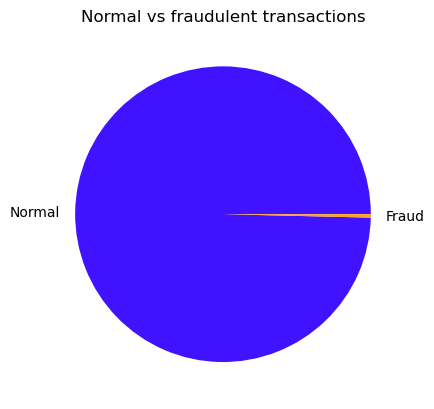

正常交易:8656497, 盜刷交易:32029


In [3]:
orange, purple = '#ffa022', '#4012ff'
fig, ax = plt.subplots()
ax.pie(df.groupby(['label']).label.count(), labels= ['Normal', 'Fraud'], colors=[purple, orange])
plt.title('Normal vs fraudulent transactions')
plt.show()

Normal = (df1['盜刷與否'] == 0).sum()
Fraud = (df1['盜刷與否'] == 1).sum()
print(f'正常交易:{Normal}, 盜刷交易:{Fraud}')

In [4]:
# 將交易序號刪除
df2 = df1.drop("交易序號", axis=1, inplace=False)


# 將授權時間由當下時鐘時間轉換為秒
df2['授權時間'] = (df1['授權時間'] // 10000) * 3600 + \
                 ((df1['授權時間'] // 100) % 100) * 60 + \
                 (df1['授權時間'] % 100)


# 將顧客ID、交易卡號、特店代號、收單行代碼四個亂碼的資料重新編碼
# train跟test的編碼有可能不一樣?
label_encoder = LabelEncoder()
df2['顧客ID'] = label_encoder.fit_transform(df1['顧客ID'])
df2['交易卡號'] = label_encoder.fit_transform(df1['交易卡號'])
df2['特店代號'] = label_encoder.fit_transform(df1['特店代號'])
df2['收單行代碼'] = label_encoder.fit_transform(df1['收單行代碼'])

# 修改交易型態Nan欄位
df2['交易型態'].value_counts(dropna=False)
df2['交易型態'].fillna(11, inplace=True) #將 Nan 改為類別 11

# 修改 支付型態 Nan欄位
df2['支付型態'].value_counts(dropna=False) #286656 Na不是類別資料
df2['支付型態'].fillna(11, inplace=True) #將 Nan 改為類別 11

# 修改狀態碼Nan欄位
df2['狀態碼'].value_counts(dropna=False)
df2['狀態碼'].fillna(5, inplace=True) #將 Nan 改為類別 5

# 修改 mcc_code、消費地國別、消費城市'消費地幣別 Nan欄位
#df2['mcc_code'].value_counts(dropna=False) #4550筆 Na不是類別資料
#df2['消費地國別'].value_counts(dropna=False) #600筆 Na不是類別資料
#df2['消費城市'].value_counts(dropna=False) #266066 Na不是類別資料
#df2['消費地幣別'].value_counts(dropna=False) #498657 Na不是類別資料

# 其餘NA刪除
df2.dropna(inplace=True)

# 觀察刪除NA後資料筆數
Normal = (df2['盜刷與否'] == 0).sum()
Fraud = (df2['盜刷與否'] == 1).sum()
print(f'正常交易:{Normal}, 盜刷交易:{Fraud}')
print(f'df2中是否存在NA: {df2.isna().any().any()}')
df2.head(5)

正常交易:8131069, 盜刷交易:31390
df2中是否存在NA: False


,授權日期,授權時間,顧客ID,交易卡號,交易類別,交易型態,特店代號,收單行代碼,mcc_code,交易金額-台幣,...,消費地國別,消費城市,狀態碼,超額註記碼,Fallback註記,支付型態,消費地幣別,消費地金額,3D交易註記,盜刷與否
0,46,37092,250232,149371,5,1.0,129782,4681,375.0,1524.0,...,0.0,15759.0,5.0,0,0,6.0,70.0,1529,0,0
1,17,32109,291130,340184,5,8.0,43169,1806,282.0,101.0,...,0.0,15759.0,5.0,0,0,8.0,70.0,101,0,0
2,44,77201,415878,74260,5,4.0,58675,4681,288.0,117.0,...,0.0,15759.0,5.0,0,0,6.0,70.0,116,0,0
3,42,37622,164678,162724,5,1.0,129782,1770,375.0,1676.0,...,0.0,15759.0,5.0,0,0,6.0,70.0,1683,0,0
4,31,68257,482590,395056,5,5.0,51790,1806,406.0,14.0,...,0.0,15759.0,5.0,0,0,6.0,70.0,14,0,0


In [5]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(19981015)

In [6]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(24, 18),
            nn.Tanh(),
            nn.Linear(18, 12),
            nn.Tanh(),
            nn.Linear(12, 3))

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 18),
            nn.Tanh(),
            nn.Linear(18, 24),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Separate fraudulent transactions from normal transactions
norm_data, fraud_data = df2[df2['盜刷與否']==0], df2[df2['盜刷與否']==1]

# Training data will be 8100000 normal samples
# Validation data will be 62459 samples, approximately half fraud and half normal samples.
# The validation data will be shuffled and the indices will be reseted
train_data = norm_data.iloc[:8100000, :]
val_data = pd.concat([norm_data.iloc[8100000:,:], fraud_data], axis =0).sample(frac=1).reset_index(drop=True)

In [12]:
#Hyper parameters
num_epochs = 75
trian_batch_size = 500000 
learning_rate = 1e-3

# Create pytorch data loader for training set
#從train_data抓出Y盜刷與否欄位並轉換成pytorch張量
train_target = torch.tensor(train_data['盜刷與否'].values.astype(np.float32)) #將train_data中的Class欄位用value轉換成numpy數組，並將型態轉換成浮點數float，再用torch.tensor轉成pytorch張量
#從train_data抓出X欄位並轉換成pytorch張量
train = torch.tensor(train_data.drop('盜刷與否', axis = 1).values.astype(np.float32))
#綁定成一個TensorDataset
train_tensor = TensorDataset(train, train_target) #將train和train_target儲存成tensordataset(類似一個List[0,1]),這是Pytorch儲存資料的型態
#用dataloader將train_tensor切分成多個batch,(suffle是將數據順序打亂)
train_loader = DataLoader(dataset = train_tensor, batch_size = trian_batch_size, shuffle = True)

# Model
#model = fcn_autoencoder().cuda()
model_type = 'fcn'
model_classes = {'fcn':fcn_autoencoder()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

In [13]:
best_loss = np.inf #無限大
model.train() #訓練模式

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description')) #設定進度條
for epoch in qqdm_train:
    tot_loss = list()
    for x in train_loader:
        
        
        data = x[0].cuda()
        output = model(data)
        loss = criterion(output, data)
        tot_loss.append(loss.item())
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                                                                       
 0/75           -             -                                                                                         
Description   0.0% |                                                                                                   | Iters    Elapsed Time      Speed                                                                                       
 1/75   00:01:30<01:52:13  0.01it/s                                                                                     
Description   1.3% |█                                                                                                  | Iters    Elapsed Time      Speed                                                                                       
 2/75   00:03:01<01:50:26  0.01it/s                                                                                     
Description   2.7% |██            

Description  20.0% |███████████████████                                                                                | Iters    Elapsed Time      Speed                                                                                       
 16/75  00:23:52<01:28:01  0.01it/s                                                                                     
Description  21.3% |█████████████████████                                                                              | Iters    Elapsed Time      Speed                                                                                       
 17/75  00:25:23<01:26:36  0.01it/s                                                                                     
Description  22.7% |██████████████████████                                                                             | Iters    Elapsed Time      Speed                                                                                       
 18/75  00:26:54<01:25:11  0.01it/s

Description  36.0% |███████████████████████████████████                                                                | Iters    Elapsed Time      Speed                                                                                       
 28/75  00:41:43<01:10:02  0.01it/s                                                                                     
Description  37.3% |████████████████████████████████████                                                               | Iters    Elapsed Time      Speed                                                                                       
 29/75  00:43:08<01:08:25  0.01it/s                                                                                     
Description  38.7% |██████████████████████████████████████                                                             | Iters    Elapsed Time      Speed                                                                                       
 30/75  00:44:34<01:06:51  0.01it/s

Description  49.3% |████████████████████████████████████████████████                                                   | Iters    Elapsed Time      Speed                                                                                       
 38/75  00:55:57<00:54:28  0.01it/s                                                                                     
Description  50.7% |██████████████████████████████████████████████████                                                 | Iters    Elapsed Time      Speed                                                                                       
 39/75  00:57:20<00:52:55  0.01it/s                                                                                     
Description  52.0% |███████████████████████████████████████████████████                                                | Iters    Elapsed Time      Speed                                                                                       
 40/75  00:58:45<00:51:24  0.01it/s

Description  61.3% |████████████████████████████████████████████████████████████                                       | Iters    Elapsed Time      Speed                                                                                       
 47/75  01:09:08<00:41:11  0.01it/s                                                                                     
Description  62.7% |██████████████████████████████████████████████████████████████                                     | Iters    Elapsed Time      Speed                                                                                       
 48/75  01:10:37<00:39:43  0.01it/s                                                                                     
Description  64.0% |███████████████████████████████████████████████████████████████                                    | Iters    Elapsed Time      Speed                                                                                       
 49/75  01:12:06<00:38:15  0.01it/s

Description  72.0% |███████████████████████████████████████████████████████████████████████                            | Iters    Elapsed Time      Speed                                                                                       
 55/75  01:21:04<00:29:29  0.01it/s                                                                                     
Description  73.3% |████████████████████████████████████████████████████████████████████████                           | Iters    Elapsed Time      Speed                                                                                       
 56/75  01:22:36<00:28:01  0.01it/s                                                                                     
Description  74.7% |█████████████████████████████████████████████████████████████████████████                          | Iters    Elapsed Time      Speed                                                                                       
 57/75  01:24:08<00:26:34  0.01it/s

Description  81.3% |████████████████████████████████████████████████████████████████████████████████                   | Iters    Elapsed Time      Speed                                                                                       
 62/75  01:31:24<00:19:10  0.01it/s                                                                                     
Description  82.7% |█████████████████████████████████████████████████████████████████████████████████                  | Iters    Elapsed Time      Speed                                                                                       
 63/75  01:33:01<00:17:43  0.01it/s                                                                                     
Description  84.0% |███████████████████████████████████████████████████████████████████████████████████                | Iters    Elapsed Time      Speed                                                                                       
 64/75  01:34:33<00:16:15  0.01it/s

Description  90.7% |█████████████████████████████████████████████████████████████████████████████████████████          | Iters    Elapsed Time      Speed                                                                                       
 69/75  01:41:51<00:08:51  0.01it/s                                                                                     
Description  92.0% |███████████████████████████████████████████████████████████████████████████████████████████        | Iters    Elapsed Time      Speed                                                                                       
 70/75  01:43:15<00:07:22  0.01it/s                                                                                     
Description  93.3% |████████████████████████████████████████████████████████████████████████████████████████████       | Iters    Elapsed Time      Speed                                                                                       
 71/75  01:44:43<00:05:54  0.01it/s

Description  98.7% |█████████████████████████████████████████████████████████████████████████████████████████████████  | Iters    Elapsed Time      Speed                                                                                       
 75/75  01:50:33<00:00:00  0.01it/s                                                                                     
Description 100.0% |███████████████████████████████████████████████████████████████████████████████████████████████████| Iters    Elapsed Time      Speed                                                                                       
 75/75  01:50:33<00:00:00  0.01it/s                                                                                     
Description 100.0% |███████████████████████████████████████████████████████████████████████████████████████████████████|

In [15]:
eval_batch_size = 500

# Create pytorch data loader for validation set
val_target = torch.tensor(val_data['盜刷與否'].values.astype(np.float32))
val = torch.tensor(val_data.drop('盜刷與否', axis=1).values.astype(np.float32))
val_tensor = TensorDataset(val, val_target)
val_loader = DataLoader(dataset=val_tensor, batch_size=eval_batch_size, shuffle=True)
val_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = 'last_model_fcn.pt'
model = torch.load(checkpoint_path)  # 載入訓練好的模型"last_model_fcn.pt"儲存為model
model.eval()  # 評估模式、測試模式

# prediction file 
out_file = 'PREDICTION_FILE.csv'

In [23]:
# 設定一個閥值threshold並計算RMSE，當RMSE超過閥值則判定為異常交易class=1
threshold = 450000
anomality = list()
all_targets = list()  # 新增這行，用於儲存所有target

with torch.no_grad():
    for test in val_loader:
        data = test[0].cuda()
        target = test[1].cuda()  # 新增這行，用於儲存target
        output = model(data)
        loss = val_loss(output, data).sum(-1)
        anomality.append(loss)
        all_targets.append(target)  # 新增這行，將target加入到all_targets列表中
        
anomality = [torch.sqrt(tensor).cpu().numpy() for tensor in anomality]
anomality = np.concatenate(anomality)  # 展平list成一維numpy數組
all_targets = torch.cat(all_targets).cpu().numpy()  # 將所有target拼接起來並轉成numpy數組

Final_df = pd.DataFrame(anomality, columns=['RMSE'])
Final_df['class'] = np.where(Final_df['RMSE'] <= threshold, 0, 1)

#print(Final_df)

# 計算F1 score
f1 = f1_score(all_targets, Final_df['class'])
print(f'F1 score: {f1:.4f}')

F1 score: 0.5017
